## PageRank and CheiRank Calculated from ScreamingFrog Crawl Data with Moz API Data

The following workflow requires two files.

* **internal_html.csv**: Is an export of HTML from Screaming Frog. The Moz API must be enabled to collect `Moz MozRank External Equity - Exact` per URL.
* **all_inlinks.csv**: Is an bulk export of all **Inlinks** from Screaming Frog.

Both files are raw exports so Column names are the defaults and the read_Csv function expects to skip the first row.

A follow up to this [tweet](https://twitter.com/willem_nout/status/1101417508685467648).

### Import Libraries

In [1]:
import networkx as nx
import pandas as pd

### Specify Some Variables

We need to specify some variables we will use later.

In [2]:
domain = "adaptpartners.com"

### Read Crawl HTML Data

Crawl with Screaming Frog and export HTML.  Ensure that you respect robots.txt, noindex, canonical, etc to try to get as close a representation to what Google gets as possible.

In [3]:
df_html = pd.read_csv('internal_html.csv', skiprows=1)
df_html = df_html[['Address','Moz MozRank External Equity - Exact', 'Outlinks']]
df_html.columns = ['Address', 'Equity', 'Outlinks']
df_html.head()

,Address,Equity,Outlinks
0,https://adaptpartners.com/,3.983756,23
1,https://adaptpartners.com/careers/,0.077778,15
2,https://adaptpartners.com/contact-us/,0.000000,14
3,https://adaptpartners.com/case-studies/,0.000000,20
4,https://adaptpartners.com/services/,0.076712,22


### Read Internal Link Data

After the prior crawl, use the Bulk Export tool to export All Inlinks. We then clean the data a bit to ensure we have only the links that we want.

In [4]:
df_links = pd.read_csv('all_inlinks.csv', skiprows=1)

# keep only Ahref and Follow
df_links = df_links[(df_links['Type'] == "AHREF") & (df_links['Follow'] == True)]
# keep only internal links
df_links = df_links[(df_links['Destination'].str.match(r'^(http:|https:)//(www.)?{}.*$'.format(domain), case=False)) & (df_links['Source'].str.match(r'^(http:|https:)//(www.)?{}.*$'.format(domain), case=False))]

# Keep only the columns we need
df_links = df_links[['Source','Destination']]

df_links.head()

,Source,Destination
0,https://adaptpartners.com/,https://adaptpartners.com/
1,https://adaptpartners.com/,https://adaptpartners.com/
2,https://adaptpartners.com/,https://adaptpartners.com/
3,https://adaptpartners.com/,https://adaptpartners.com/
4,https://adaptpartners.com/,https://adaptpartners.com/


### Clean the Links in Both Datasets

In [5]:
from urllib.parse import urlparse

# This may or may not be what you want to do depending on the site and can, for sure be extended to keep important querystings or consolidate canoncicals.
def apply_clean_links(row):
    
    cols=['Address', 'Source', 'Destination']
    
    for c in cols:
        if c in row:
            row[c] = urlparse(row[c]).path
        
    return row


df_links = df_links.apply(apply_clean_links, axis=1)
df_html = df_html.apply(apply_clean_links, axis=1)

#Consolidate External Equity
df_html = df_html.groupby([ 'Address'], as_index=False).agg({"Equity": "max","Outlinks":"max"})


df_html.head()

,Address,Equity,Outlinks
0,/,3.983756,23
1,/about-us/,0.079452,40
2,/about-us/amanda-fennell/,0.000000,16
3,/about-us/amanda-jordan/,0.000000,15
4,/about-us/caitlin-vargas/,0.000000,16


### Set Up the Graphs

In [9]:
def traverse_dataframe(df, addresses, graph, gtype= "PR"):
    
    for i, row in df.iterrows():
        
        # Add nodes
        if 'Address' in row:
            if graph.has_node(row['Address']) == False:
                graph.add_node(row['Address'])
        # Add edges
        elif 'Destination' in row and 'Source' in row:
            #Skip adding edge if source or destination is not in set of pages.
            if not row['Destination'] in addresses or not row['Source'] in addresses:
                continue
            if gtype == 'PR':
                graph.add_edge(row['Source'], row['Destination'])
            else:
                graph.add_edge(row['Destination'], row['Source'])
            
        else:
            raise Exception('The correct dataframes were not supplied.  Expecting either `Address` or `Destination` and `Source` columns.')
            
            

def run_graphs(df_links, df_html):

    pr_graph = nx.DiGraph()
    cr_graph = nx.DiGraph()
    
    addresses = df_html['Address'].tolist()
    
    # Pagerank Graph
    traverse_dataframe(df_html, addresses, pr_graph, gtype= "PR")
    traverse_dataframe(df_links, addresses, pr_graph, gtype= "PR")
                  
    # CheiRank Graph
    traverse_dataframe(df_html, addresses, cr_graph, gtype= "CR")
    traverse_dataframe(df_links, addresses, cr_graph, gtype= "CR")
    
    
    return pr_graph, cr_graph
    
    

pr_graph, cr_graph = run_graphs(df_links, df_html)

### Get initial weights from Moz External Equity and run PageRank and CheiRank

In [10]:
adr= df_html['Address'].tolist()
eqt= df_html['Equity'].tolist()

init_nstart = {v:eqt[i] for i,v in enumerate(adr)}

scores_pr = nx.pagerank(pr_graph, nstart=init_nstart)
scores_cr = nx.pagerank(cr_graph, nstart=init_nstart)

### Plot PageRank and CheiRank Graph

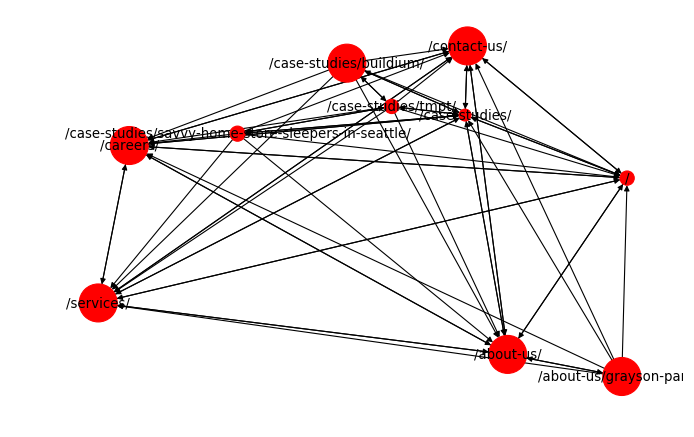

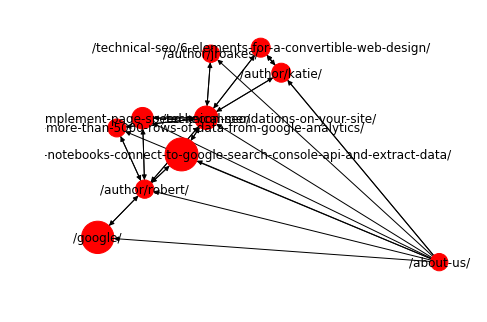

In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

topn = 10

if scores_pr:
    # Sort nodes by best
    ranked_nodes_pr = sorted(((scores_pr[s],s) for i,s in enumerate(list(scores_pr.keys()))), reverse=True)
    # Get the topn nodes
    nodelist = [n[1] for n in ranked_nodes_pr][:topn]
    edgelist = [(a[0],a[1]) for a in pr_graph.edges() if a[0] in nodelist and a[1] in nodelist]
    labels = {n:n for n in nodelist}
    sizes_pr = [(scores_pr[x])*10000 for x in list(scores_pr) if x in nodelist]   
    sm = nx.draw(pr_graph, with_labels = True, node_size=sizes_pr, nodelist=nodelist, edgelist=edgelist, labels=labels)
    plt.show()
    
if scores_cr:
    # Sort nodes by best
    ranked_nodes_cr = sorted(((scores_cr[s],s) for i,s in enumerate(list(scores_cr.keys()))), reverse=True)
    # Get the topn nodes
    nodelist = [n[1] for n in ranked_nodes_cr][:topn]
    edgelist = [(a[0],a[1]) for a in cr_graph.edges() if a[0] in nodelist and a[1] in nodelist]
    labels = {n:n for n in nodelist}
    sizes_cr = [(scores_cr[x])*10000 for x in list(scores_cr) if x in nodelist]   
    sm = nx.draw(cr_graph, with_labels = True, node_size=sizes_cr, nodelist=nodelist, edgelist=edgelist, labels=labels)
    plt.show()

### Save to a CSV

In [19]:
def apply_scores(row,scores_pr,scores_cr):
    adr = row['Address']
    otl = int(row['Outlinks'])
    row['PageRank'] = scores_pr.get(adr,0)
    row['CheiRank'] = scores_cr.get(adr,0)
    row['Link Equity'] = float(scores_cr.get(adr,0)/otl)
   
    return row

df_html = df_html.apply(apply_scores, args=(scores_pr,scores_cr), axis=1)

df_html.head()

,Address,Equity,Outlinks,PageRank,CheiRank,Link Equity
0,/,3.983756,23,0.116780,0.005853,0.000254
1,/about-us/,0.079452,40,0.116780,0.054467,0.001362
2,/about-us/amanda-fennell/,0.000000,16,0.011090,0.013831,0.000864
3,/about-us/amanda-jordan/,0.000000,15,0.009891,0.009781,0.000652
4,/about-us/caitlin-vargas/,0.000000,16,0.011108,0.012300,0.000769
